In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 4, 4)
        x = nn.functional.relu(self.deconv1(x))
        x = nn.functional.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

In [ ]:
# Hyper-parameters
latent_dim = 128
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# Model
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        encoded = encoder(images)
        decoded = decoder(encoded)
        # loss = criterion(decoded, images)

        decoded = nn.functional.interpolate(decoded, size=(28,28))

        loss = nn.functional.mse_loss(decoded, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Testing
ssim_scores = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        encoded = encoder(images)
        decoded = decoder(encoded)
        decoded = nn.functional.interpolate(decoded, size=(28,28))
        # recon_images = decoded

for i in range(images.size(0)):
    ssim_score = ssim(images[i].cpu().numpy().squeeze(), decoded[i].cpu().numpy().squeeze())
    ssim_scores.append(ssim_score)

print(f'Average SSIM Score: {sum(ssim_scores) / len(ssim_scores)}')


100%|██████████| 9912422/9912422 [00:00<00:00, 131790581.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70674267.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 105171863.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3039816.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/10], Loss: 0.0218
Epoch [2/10], Loss: 0.0049
Epoch [3/10], Loss: 0.0035
Epoch [4/10], Loss: 0.0029
Epoch [5/10], Loss: 0.0025
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0020
Epoch [8/10], Loss: 0.0019
Epoch [9/10], Loss: 0.0018
Epoch [10/10], Loss: 0.0017
Average SSIM Score: 0.9879146455055919


Sigma = 0.1 Epoch [1/10], Loss: 0.0235
Sigma = 0.1 Epoch [2/10], Loss: 0.0059
Sigma = 0.1 Epoch [3/10], Loss: 0.0045
Sigma = 0.1 Epoch [4/10], Loss: 0.0038
Sigma = 0.1 Epoch [5/10], Loss: 0.0034
Sigma = 0.1 Epoch [6/10], Loss: 0.0032
Sigma = 0.1 Epoch [7/10], Loss: 0.0030
Sigma = 0.1 Epoch [8/10], Loss: 0.0028
Sigma = 0.1 Epoch [9/10], Loss: 0.0027
Sigma = 0.1 Epoch [10/10], Loss: 0.0026
Sigma: 0.1, Average SSIM Score: 0.9821418240620208
Sigma = 0.3 Epoch [1/10], Loss: 0.0247
Sigma = 0.3 Epoch [2/10], Loss: 0.0089
Sigma = 0.3 Epoch [3/10], Loss: 0.0074
Sigma = 0.3 Epoch [4/10], Loss: 0.0068
Sigma = 0.3 Epoch [5/10], Loss: 0.0064
Sigma = 0.3 Epoch [6/10], Loss: 0.0061
Sigma = 0.3 Epoch [7/10], Loss: 0.0060
Sigma = 0.3 Epoch [8/10], Loss: 0.0058
Sigma = 0.3 Epoch [9/10], Loss: 0.0057
Sigma = 0.3 Epoch [10/10], Loss: 0.0056
Sigma: 0.3, Average SSIM Score: 0.9705913319668062
Sigma = 0.5 Epoch [1/10], Loss: 0.0288
Sigma = 0.5 Epoch [2/10], Loss: 0.0129
Sigma = 0.5 Epoch [3/10], Loss: 0.0117

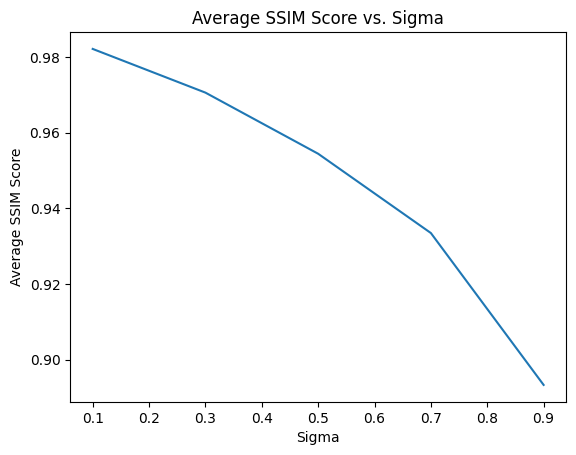

In [ ]:
# Hyper-parameters
latent_dim = 128
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Gaussian noise function
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

# Training with different sigma values
sigma_values = [0.1, 0.3, 0.5, 0.7, 0.9]
ssim_scores = []

for sigma in sigma_values:
    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    # criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, _) in enumerate(train_loader):
            optimizer.zero_grad()

            images = images.to(device)
            noisy_images = add_gaussian_noise(images, sigma)
            encoded = encoder(noisy_images)
            decoded = decoder(encoded)
            # loss = criterion(decoded, images)

            decoded = nn.functional.interpolate(decoded, size=(28,28))

            loss = nn.functional.mse_loss(decoded, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Sigma = {sigma} Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Testing
    # encoder.eval()
    # decoder.eval()
    test_ssim_scores = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            encoded = encoder(images)
            decoded = decoder(encoded)
            decoded = nn.functional.interpolate(decoded, size=(28,28))

    for i in range(images.size(0)):
        ssim_score = ssim(images[i].cpu().numpy().squeeze(), decoded[i].cpu().numpy().squeeze())
        test_ssim_scores.append(ssim_score)

    avg_ssim_score = sum(test_ssim_scores) / len(test_ssim_scores)
    ssim_scores.append(avg_ssim_score)
    print(f'Sigma: {sigma}, Average SSIM Score: {avg_ssim_score}')


# Plot average SSIM scores for different sigma values
plt.plot(sigma_values, ssim_scores)
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs. Sigma')
plt.show()


Latent Dim: 16 Epoch [1/10], Loss: 0.0281
Latent Dim: 16 Epoch [2/10], Loss: 0.0124
Latent Dim: 16 Epoch [3/10], Loss: 0.0111
Latent Dim: 16 Epoch [4/10], Loss: 0.0104
Latent Dim: 16 Epoch [5/10], Loss: 0.0099
Latent Dim: 16 Epoch [6/10], Loss: 0.0096
Latent Dim: 16 Epoch [7/10], Loss: 0.0094
Latent Dim: 16 Epoch [8/10], Loss: 0.0092
Latent Dim: 16 Epoch [9/10], Loss: 0.0090
Latent Dim: 16 Epoch [10/10], Loss: 0.0089
Latent Dim: 16, Average SSIM Score: 0.9371776668814756
Latent Dim: 32 Epoch [1/10], Loss: 0.0258
Latent Dim: 32 Epoch [2/10], Loss: 0.0077
Latent Dim: 32 Epoch [3/10], Loss: 0.0062
Latent Dim: 32 Epoch [4/10], Loss: 0.0056
Latent Dim: 32 Epoch [5/10], Loss: 0.0053
Latent Dim: 32 Epoch [6/10], Loss: 0.0051
Latent Dim: 32 Epoch [7/10], Loss: 0.0049
Latent Dim: 32 Epoch [8/10], Loss: 0.0048
Latent Dim: 32 Epoch [9/10], Loss: 0.0047
Latent Dim: 32 Epoch [10/10], Loss: 0.0046
Latent Dim: 32, Average SSIM Score: 0.968481408536034
Latent Dim: 64 Epoch [1/10], Loss: 0.0228
Latent 

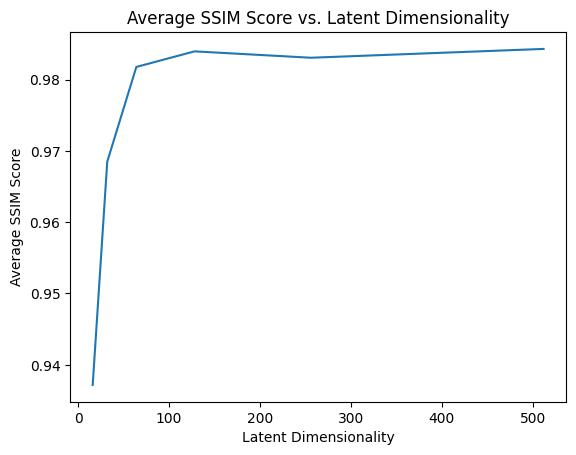

In [ ]:
# Hyper-parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
sigma = 0.1  # Constant sigma value for Gaussian noise

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Gaussian noise function
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images


# Training with different latent_dim values
latent_dim_values = [16, 32, 64, 128, 256, 512]
ssim_scores = []

for latent_dim in latent_dim_values:
    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    # criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, _) in enumerate(train_loader):
            optimizer.zero_grad()
            images = images.to(device)
            noisy_images = add_gaussian_noise(images, sigma)
            encoded = encoder(noisy_images)
            decoded = decoder(encoded)
            # loss = criterion(decoded, images)

            decoded = nn.functional.interpolate(decoded, size=(28,28))

            loss = nn.functional.mse_loss(decoded, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Latent Dim: {latent_dim} Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Testing
    # encoder.eval()
    # decoder.eval()
    test_ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            encoded = encoder(images)
            decoded = decoder(encoded)
            decoded = nn.functional.interpolate(decoded, size=(28,28))
    for i in range(images.size(0)):
        ssim_score = ssim(images[i].cpu().numpy().squeeze(), decoded[i].cpu().numpy().squeeze())
        test_ssim_scores.append(ssim_score)

    avg_ssim_score = sum(test_ssim_scores) / len(test_ssim_scores)
    ssim_scores.append(avg_ssim_score)
    print(f'Latent Dim: {latent_dim}, Average SSIM Score: {avg_ssim_score}')


# Plot average SSIM scores for different latent_dim values
plt.plot(latent_dim_values, ssim_scores)
plt.xlabel('Latent Dimensionality')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs. Latent Dimensionality')
plt.show()

### Observations:

1. **Task 2 - Varying Sigma**:
   - As sigma increases, representing higher levels of Gaussian noise, the SSIM test score tends to decrease. This is expected as higher noise levels introduce more distortions, making it harder for the model to reconstruct the images accurately.
   - The SSIM score decreases as the noise level increases, indicating that the model's performance degrades with higher noise levels.

2. **Task 3 - Varying Bottleneck Dimensionality**:
   - Generally, increasing the bottleneck dimensionality allows the model to capture more information about the input images, potentially leading to better reconstructions.
   - However, this improvement may not be significant beyond a certain point. In some cases, increasing the bottleneck dimensionality too much might lead to overfitting or inefficiency.
   - The SSIM test scores might increase initially with increasing bottleneck dimensionality, but they may plateau or even decrease beyond a certain dimensionality. This suggests that there's an optimal bottleneck dimensionality for this specific model and dataset.
   
In conclusion, these observations emphasize the importance of finding an optimal balance between model complexity (bottleneck dimensionality) and noise resilience (sigma value) for effective image reconstruction in autoencoders.